In [1]:
import scipy.io as sio
import os
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import logging


In [4]:
logging.basicConfig(level=logging.ERROR , filename='./logs/data_validation.log', filemode='w', format='%(asctime)s - %(levelname)s - %(message)s')


In [5]:
Preprocessed_dir = './processed'


In [6]:
def load_preprocessed_data (preprocessed_dir):
    # Load preprocessed data
    files = [f for f in os.listdir(preprocessed_dir) if f.endswith('.mat')]
    
    # Inititalize data
    eeg_data = {}
    labels_map = {1:0 , 2:1 , 3:2}
    
    for file in files:
        # Parse subject ID and label
        subject_id , emotion_label, _ = file.split('_')
        subject_id = int(subject_id)
        emotion_label = labels_map[int(emotion_label)]
        
        # prinnt(subject_id , emotion_label)
        # print(subject_id , emotion_label)
        
        # Load data
        data = sio.loadmat(os.path.join(preprocessed_dir , file))
        trial_data = data['data']['trial'][0][0]
        
        #print(trial_data)
        
        if subject_id not in eeg_data:
            eeg_data[subject_id] = {}
        if emotion_label not in eeg_data[subject_id]:
            eeg_data[subject_id][emotion_label] = []
        eeg_data[subject_id][emotion_label].append(trial_data)
        
    print(f"loaded data for {len(eeg_data)} subjects")
    
    # validate data 
    for subject , trial_data in eeg_data.items():
        for label, trial_list in trial_data.items():
            for trial in trial_list:
                if not isinstance(trial,np.ndarray):
                    logging.error(f"Invalid trial type for subject {subject} and label {label} : {type(trial)}")
                    print(f"Invalid trial type for subject {subject} and label {label} : {type(trial)}")
                
    # print(eeg_data.values)
    # for subject, trial_data in eeg_data.items():
    #     for label, trial_list in trial_data.items():
    #         for trial in trial_list:
    #             print(f"Subject: {subject}, Label: {label}, Data: {trial}")
    
    return eeg_data

In [7]:
def visualize_data_distribution (eeg_data):
    emotion_counts = {}
    for subject,data in eeg_data.items():
        for emotion , trials in data.items():
            emotion_counts[emotion] = emotion_counts.get(emotion,0) + len(trials)
            
    plt.bar(emotion_counts.keys() , emotion_counts.values())
    plt.xlabel('Emotion labels')
    plt.ylabel('Number of trials')
    plt.title('Data distribution')
    plt.show()

loaded data for 15 subjects


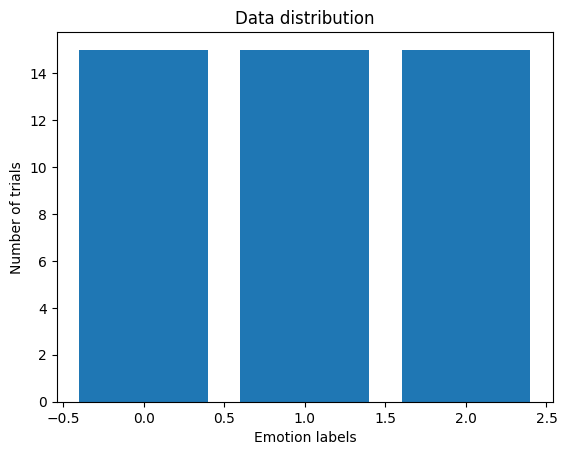

In [8]:
if __name__ == '__main__':
    # Load preprocessed data
   eeg_data = load_preprocessed_data(Preprocessed_dir)
   
   #visualize the data distribution
   visualize_data_distribution(eeg_data)